# Fourier Transform

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

## Discrete Fourier Transform DFT

In the signal processing literature the DFT is expressed as: 

$$
X[k] = \sum_{n=0}^{N-1} x[n]  e^{-j2 \pi kn/N} \hspace{1cm} k=0,1,2,...,N-1
$$

Where:

$x[n] =$ discrete input signal at time [sample] $n$

$n =$ sample number (integer)

$X[k] = k$ th spectral sample

$w_k = k\Omega = k$ th frequency sample (rad/sec)

$\Omega = \dfrac{2\pi}{NT}$

$f_s = \dfrac{1}{T}$ 

$N = $ number of samples in both time and frequency

$j = \sqrt{-1}$     or    $j = -1^2$ 

$e = \lim_{n\to\inf} (1 + \dfrac{1}{n})^n = 2.71828182845905...$

## Inverse Discrete Fourier Transform IDFT  

$$
x(n) = \frac{1}{N}\sum_{k=0}^{N-1} X[k]  e^{j2 \pi nk/N} \hspace{1cm} n=0,1,2,...,N-1
$$

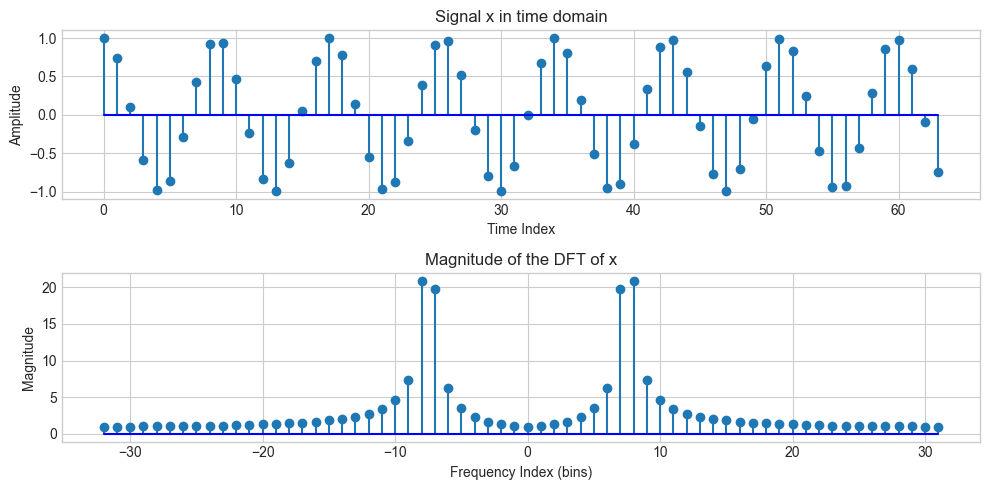

In [17]:
# "Manually" compute the DFT of a signal x

N = 64  # length of the signal x
k0 = 7.5    # frequency of the complex exponential
x = np.cos(2 * np.pi * k0 / N * np.arange(N))

X = np.array([])            # placeholder for the DFT of x
nv = np.arange(-N/2, N/2)   # time index
kv = np.arange(-N/2, N/2)   # frequency index

for k in kv:
    s = np.exp(1j * 2 * np.pi * k / N * np.arange(N))
    X = np.append(X, sum(x * np.conjugate(s)))


fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plt.title('DFT of a signal x')
# Plot the signal x
ax[0].stem(np.arange(0, N), x, basefmt='b-')
ax[0].set_title('Signal x in time domain')
ax[0].set_xlabel('Time Index')
ax[0].set_ylabel('Amplitude')

# Plot the magnitude of the DFT X
ax[1].stem(kv, np.abs(X), basefmt='b-')
ax[1].set_title('Magnitude of the DFT of x')
ax[1].set_xlabel('Frequency Index (bins)')
ax[1].set_ylabel('Magnitude')

# plt.subplots_adjust(top=2.0)  # Adjust the top padding
plt.tight_layout()
plt.show()

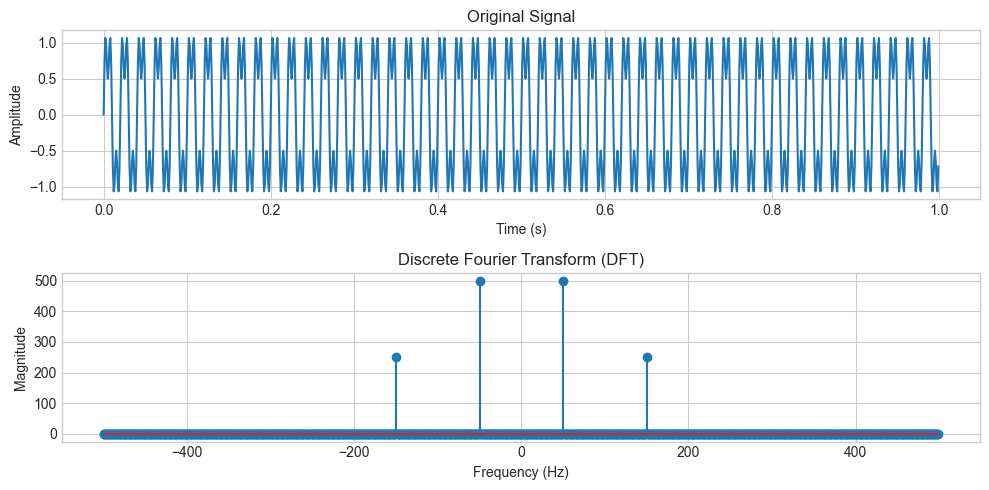

In [15]:
# Function to compute DFT
def compute_dft(signal):
    N = len(signal)
    X = np.zeros(N, dtype=np.complex128)

    for k in range(N):
        X[k] = np.sum(signal * np.exp(-1j * 2 * np.pi * k * np.arange(N) / N))

    return X

# Parameters
fs = 1000  # Sampling frequency in Hz
T = 1/fs   # Sampling period
duration = 1  # Signal duration in seconds
t = np.arange(0, duration, T)  # Time array

# Create a signal composed of two sinusoids
frequencies = [50, 150]
signal = np.sin(2 * np.pi * frequencies[0] * t) + 0.5 * np.sin(2 * np.pi * frequencies[1] * t)

# Compute DFT of the signal
dft_result = compute_dft(signal)

# Plot the original signal
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
frequencies_dft = np.fft.fftfreq(len(dft_result), T)
plt.stem(frequencies_dft, np.abs(dft_result))
plt.title('Discrete Fourier Transform (DFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()

## Fourier properties

With this exercise you will get a better understanding of some of the Fourier theorems and of some useful properties of the DFT. You will write code to implement and verify several properties of the DFT that are discussed in the lectures. You will also learn to use the `dftModel.py` module of sms-tools, which contains the basic python functions implementing the DFT. There are five parts in the exercise: 1) Minimize energy spread in DFT of sinusoids, 2) Symmetry properties of the DFT, 3) Suppressing frequency components using DFT model, and 4) FFT size and zero-padding. 

### Relevant Concepts

__DFT of sinusoids:__ When a real sinusoid has an integer number of cycles in $N$ samples, the frequency of the sinusoid exactly matches one of the bin frequencies in an $N$ point DFT. Hence the DFT spectrum of the sinusoid has a value of zero at every DFT bin except at the two bins that match the frequency of the sinusoid. Otherwise, the energy of the sinusoid is spread over all the bins. When there are multiple sinusoids, the equations extend to each sinusoid. 

$$
x[n]=A_{0}\cos\left(2\pi k_{0}n/N\right)=\frac{A_{0}}{2}{\textstyle e}^{j2\pi k_{0}n/N}+\frac{A_{0}}{2}{\textstyle e}^{-j2\pi k_{0}n/N}
\\
X[k]=\frac{A_0}{2} \,\,\, \mathrm{for} \,\,\, k = k_0, -k_0; \,\,\,\, 0 \,\,\,\mathrm{otherwise}
$$

__Zero-padding:__ Zero-padding a signal is done by adding zeros at the end of the signal. If we perform zero-padding to a signal before computing its DFT, the resulting spectrum will be an interpolated version of the spectrum of the original signal.  In most implementations of the DFT (including the FFT algorithms) when the DFT size is larger than the length of the signal, zero-padding is implicitly done. 

__Zero phase windowing:__ Zero phase windowing of a frame of a signal puts the centre of the signal at the zero time index for DFT computation. By moving the centre of the frame to zero index by a circular shift, the computed DFT will not have the phase offset which would have otherwise been introduced (recall that a shift of the signal causes the DFT to be multiplied by a complex exponential, which keeps the magnitude spectrum intact but changes the phase spectrum). When used in conjunction with zero-padding, zero phase windowing is also useful for the creation of a frame of length of power of 2 for FFT computation (`fftbuffer`). 

If the length of the signal $x$ is $M$ and the required DFT size is $N$, the zero phase windowed version of the signal, `dftbuffer`, for DFT computation can be obtained by (works for both even and odd $M$): 

    hM1 = floor((M+1)/2)
    hM2 = floor(M/2)
    dftbuffer = zeros(N)
    dftbuffer[:hM1] = x[hM2:]                              
    dftbuffer[-hM2:] = x[:hM2]

__Real, even and odd signals:__ A signal is real when it does not have any imaginary component, and all sounds are real signals. A signal $x$ is even if $x[n] = x[-n]$, and odd if $x[n] = -x[-n]$. For a signal of length $M$ (and $M$ is odd), in the context of a zero phase windowed signal and its DFT, the signal is even if $x[n] = x[M-n]$ and odd if $x[n] = -x[M-n]$, $1 \leq n \leq M-1$. The DFT properties show that for real input signals, the magnitude spectrum is even and the phase spectrum is odd. Furthermore, when the input signal is both real and even, the DFT is real valued, with an even magnitude spectrum and imaginary component equal to zero. In summary, if $x$ is an input signal of length $M$ ($M$ is odd) and $X = \mathrm{DFT}(x,M)$, then for $1 \leq k \leq M-1$

If $x$ is real, $\left|X[k]\right| = \left|X[M-k]\right|$ and $\boldsymbol{<}\!X[k] = -\boldsymbol{<}\!X[M-k]$

If $x$ is real and even, $\left|X[k]\right| = \left|X[M-k]\right|$ and $\mathrm{imag}(X[k]) = 0$


__Positive half of the DFT spectrum:__ Audio signals are real signals. Due to the symmetry properties of the DFT of a real signal, it is sufficient to store only one half of the magnitude and phase spectra. To save on both storage and computation, we will just store just the half spectrum when possible. 

From an $N$ point DFT ($N$ even), we can obtain the positive half of the spectrum by considering only the first $(N/2)+1$ samples of the DFT. We can compute the magnitude spectrum of the positive half (in dB) as $m_X = 20\log_{10}\left|X[0:(N/2)+1]\right|$, where $X$ is the DFT of the input. 

__Filtering:__ Filtering involves selectively suppressing certain frequencies present in the signal. Filtering is often performed in the time domain by the convolution of the input signal with the impulse response of a filter. The same operation can also be done in the DFT domain using the properties of DFT, by multiplying the DFT of the input signal by the DFT of the impulse response of the filter. In this assignment, we will consider a very simple illustrative filter that suppresses some frequency components by setting some DFT coefficients to zero. It is to be noted that the convolution operation here is circular convolution with a period $N$, the size of the DFT. 

If $x_1[n] \Leftrightarrow X_1[k]$ and $x_2[n] \Leftrightarrow X_2[k]$, $x_1[n] * x_2[n] \Longleftrightarrow X_1[k]\,X_2[k]$

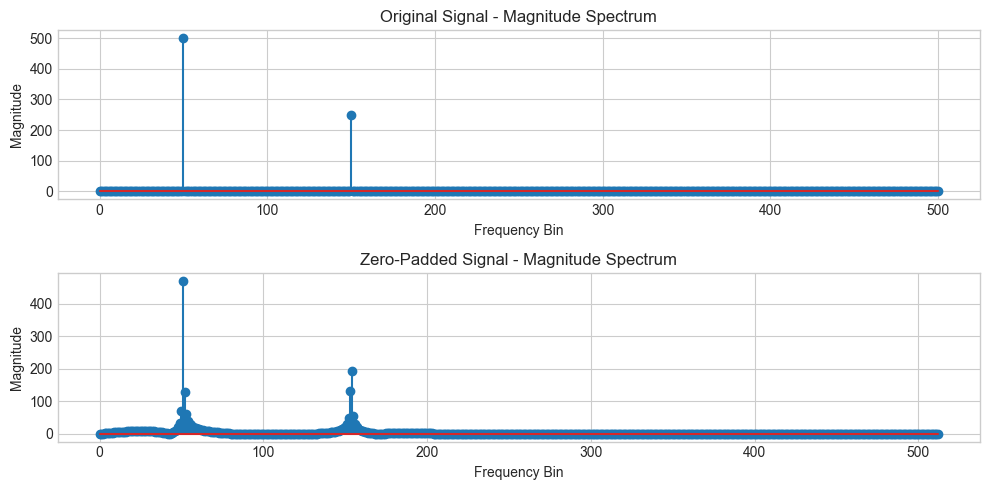

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute DFT
def compute_dft(signal):
    return np.fft.fft(signal)

# Parameters
fs = 1000  # Sampling frequency in Hz
T = 1/fs   # Sampling period
duration = 1  # Signal duration in seconds
t = np.arange(0, duration, T)  # Time array

# Create a signal composed of two sinusoids
frequencies = [50, 150]
signal = np.sin(2 * np.pi * frequencies[0] * t) + 0.5 * np.sin(2 * np.pi * frequencies[1] * t)

# Compute DFT of the original signal
dft_result_original = compute_dft(signal)

# Zero-padding to minimize energy spread
N_padded = 1024  # Choose a power of 2 for zero-padding
signal_padded = np.pad(signal, (0, N_padded - len(signal)))

# Compute DFT of the zero-padded signal
dft_result_padded = compute_dft(signal_padded)

# Plot the magnitude spectrum before and after zero-padding
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.stem(np.abs(dft_result_original[:len(dft_result_original)//2 + 1]))
plt.title('Original Signal - Magnitude Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')

plt.subplot(2, 1, 2)
plt.stem(np.abs(dft_result_padded[:len(dft_result_padded)//2 + 1]))
plt.title('Zero-Padded Signal - Magnitude Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

## Short Time Fourier Transform STFT

### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated. 
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum. 

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases} 
 \end{equation}